In [ ]:
!pip install pandas numpy matplotlib seaborn nltk spacy tensorflow nlpaug
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import nlpaug.augmenter.word as naw
import os




In [ ]:
!pip install nlpaug


In [ ]:
combined_df=pd.read_csv('preprocessed_combined_clean_datasetfinal.csv')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Combine original and augmented data

# Prepare data
X = combined_df['text'].values
y = combined_df['sentiment'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the dataset into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42, stratify=y_train_full)
print('done!')

done!


In [ ]:

# Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Load pre-trained GloVe embeddings
embedding_index = {}
embedding_dim = 100  # Using 100-dimensional GloVe embeddings
# Download GloVe embeddings if not present
glove_file = 'glove.6B.100d.txt'
if not os.path.exists(glove_file):
    print("Downloading GloVe embeddings...")
    !pip install wget # Install the wget module
    import wget
    url = 'http://nlp.stanford.edu/data/glove.6B.zip'
    wget.download(url)
    # Unzip the file
    import zipfile
    with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=071512430038afa8244a3f0979f0c72d1fcada44a4414b6b3deb0f5b0062698b
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:

# Read the embeddings
print("Loading GloVe embeddings...")
with open(glove_file, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients

# Create embedding matrix
word_index = tokenizer.word_index
num_words = min(20000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= 20000:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


Loading GloVe embeddings...


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Reduce LSTM units
model.add(Dropout(0.7))
model.add(Bidirectional(LSTM(32)))  # Reduce LSTM units
model.add(Dropout(0.7))
model.add(Dense(len(le.classes_),activation='softmax')) # Use le.classes instead of le.classes_

# Compile and train as usual

from tensorflow.keras.optimizers import Adam

# Compile the model with a smaller learning rate
optimizer = Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print("\nModel Summary:")
model.summary()


Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_pad, y_train,
                    epochs=10,  # Set high number of epochs
                    batch_size=32,
                    validation_data=(X_val_pad, y_val),
                    callbacks=[early_stopping])

# Make predictions on the test set
# Evaluate the model on the test set
y_test_pred_prob = model.predict(X_test_pad)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Calculate test accuracy and classification report
test_accuracy = accuracy_score(y_test, y_test_pred)

# Save the final model
model.save('lstm_model.h5')

# Save predictions to CSV
lstm_predictions_df = pd.DataFrame({
    'prediction': y_test_pred,
    'true_label': y_test
})
lstm_predictions_df.to_csv('lstm_predictions.csv', index=False)

#################################
classification_rep = classification_report(y_test, y_test_pred, target_names=le.classes_)

Epoch 1/10
5560/5560 ━━━━━━━━━━━━━━━━━━━━ 134s 22ms/step - accuracy: 0.4557 - loss: 1.0335 - val_accuracy: 0.6031 - val_loss: 0.8684
Epoch 2/10
5560/5560 ━━━━━━━━━━━━━━━━━━━━ 134s 22ms/step - accuracy: 0.5974 - loss: 0.8830 - val_accuracy: 0.6338 - val_loss: 0.8178
Epoch 3/10
5560/5560 ━━━━━━━━━━━━━━━━━━━━ 138s 21ms/step - accuracy: 0.6264 - loss: 0.8398 - val_accuracy: 0.6474 - val_loss: 0.7977
Epoch 4/10
5560/5560 ━━━━━━━━━━━━━━━━━━━━ 141s 21ms/step - accuracy: 0.6406 - loss: 0.8181 - val_accuracy: 0.6577 - val_loss: 0.7793
Epoch 5/10
5560/5560 ━━━━━━━━━━━━━━━━━━━━ 142s 21ms/step - accuracy: 0.6516 - loss: 0.8000 - val_accuracy: 0.6616 - val_loss: 0.7687
Epoch 6/10
5560/5560 ━━━━━━━━━━━━━━━━━━━━ 141s 21ms/step - accuracy: 0.6596 - loss: 0.7882 - val_accuracy: 0.6702 - val_loss: 0.7558
Epoch 7/10
5560/5560 ━━━━━━━━━━━━━━━━━━━━ 119s 21ms/step - accuracy: 0.6655 - loss: 0.7765 - val_accuracy: 0.6722 - val_loss: 0.7543
Epoch 8/10
5560/5560 ━━━━━━━━━━━━━━━━━━━━ 140s 21ms/step - accuracy: 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming y_test contains the true labels and y_test_pred contains the predicted labels
# If you haven't done this already:
# y_test_pred = np.argmax(lstm_probabilities, axis=1)  # Get predicted class from probabilities

# Accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy:.2f}")

# Precision, Recall, and F1-Score for each class
precision = precision_score(y_test, y_test_pred, average=None)  # Precision for each class
recall = recall_score(y_test, y_test_pred, average=None)        # Recall for each class
f1 = f1_score(y_test, y_test_pred, average=None)                # F1-Score for each class

# Printing results for each class
class_names = ['negative', 'neutral', 'positive']
for i, class_name in enumerate(class_names):
    print(f"{class_name.capitalize()} - Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1-Score: {f1[i]:.2f}")

# Overall Precision, Recall, F1-Score (macro, micro, or weighted averaging)
overall_precision = precision_score(y_test, y_test_pred, average='macro')
overall_recall = recall_score(y_test, y_test_pred, average='macro')
overall_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"\nOverall (Macro) Precision: {overall_precision:.2f}")
print(f"Overall (Macro) Recall: {overall_recall:.2f}")
print(f"Overall (Macro) F1-Score: {overall_f1:.2f}")

# Optionally, full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_names))


Accuracy: 0.68
Negative - Precision: 0.68, Recall: 0.66, F1-Score: 0.67
Neutral - Precision: 0.62, Recall: 0.73, F1-Score: 0.67
Positive - Precision: 0.80, Recall: 0.64, F1-Score: 0.71

Overall (Macro) Precision: 0.70
Overall (Macro) Recall: 0.67
Overall (Macro) F1-Score: 0.68

Classification Report:
              precision    recall  f1-score   support

    negative       0.68      0.66      0.67     13999
     neutral       0.62      0.73      0.67     19975
    positive       0.80      0.64      0.71     15443

    accuracy                           0.68     49417
   macro avg       0.70      0.67      0.68     49417
weighted avg       0.69      0.68      0.68     49417



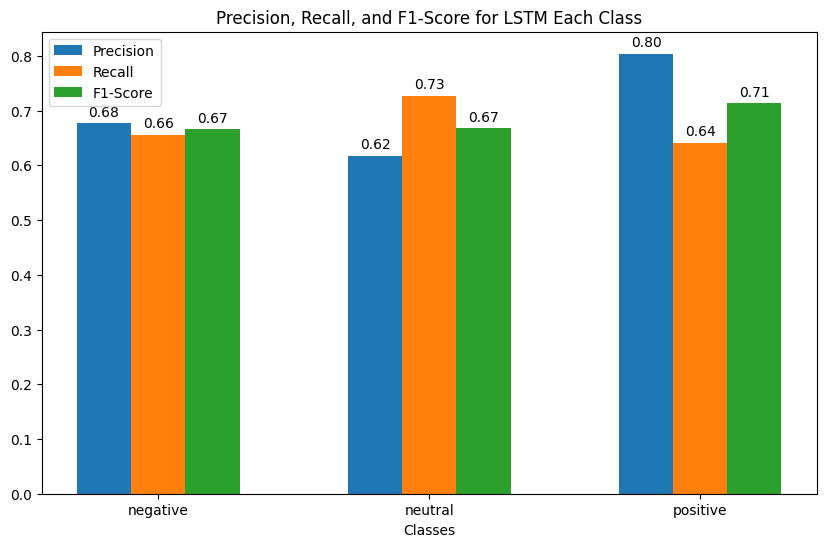

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming y_test contains the true labels and y_test_pred contains the predicted labels
# y_test_pred = np.argmax(lstm_probabilities, axis=1)  # Get predicted class from probabilities

# Class names
class_names = ['negative', 'neutral', 'positive']

# Accuracy
accuracy = accuracy_score(y_test, y_test_pred)

# Precision, Recall, and F1-Score for each class
precision = precision_score(y_test, y_test_pred, average=None)  # Precision for each class
recall = recall_score(y_test, y_test_pred, average=None)        # Recall for each class
f1 = f1_score(y_test, y_test_pred, average=None)                # F1-Score for each class

# Create a bar chart for Precision, Recall, F1-Score for each class
x = np.arange(len(class_names))  # label locations

fig, ax = plt.subplots(figsize=(10, 6))

# Bar widths and offsets
width = 0.2
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1-Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classes')
ax.set_title('Precision, Recall, and F1-Score for LSTM Each Class')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

# Annotate bars with values
def annotate_bars(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(rects1)
annotate_bars(rects2)
annotate_bars(rects3)

plt.show()




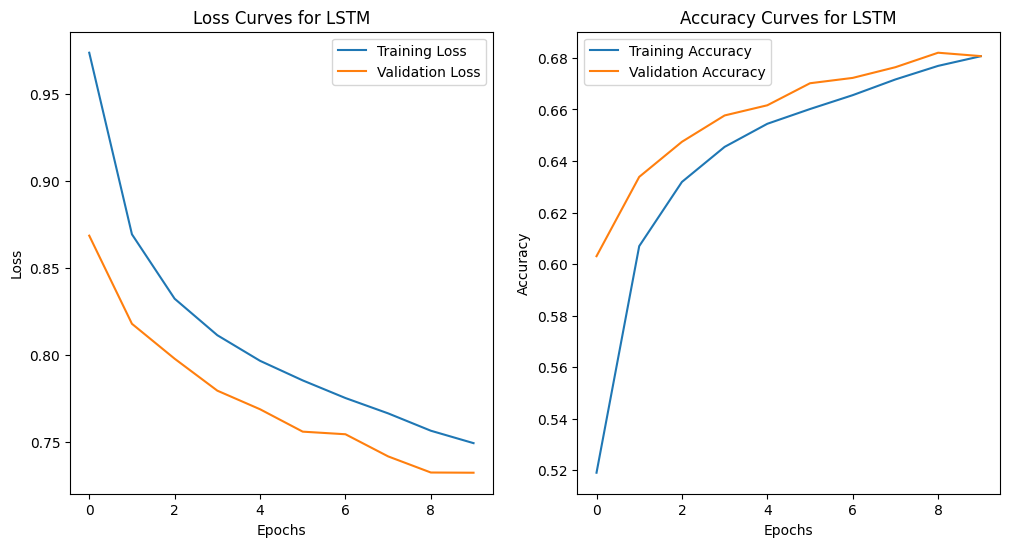

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss/Accuracy Curves
def plot_training_curves(history):
    # Loss Curves
    plt.figure(figsize=[12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curves for LSTM')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curves for LSTM')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

plot_training_curves(history)


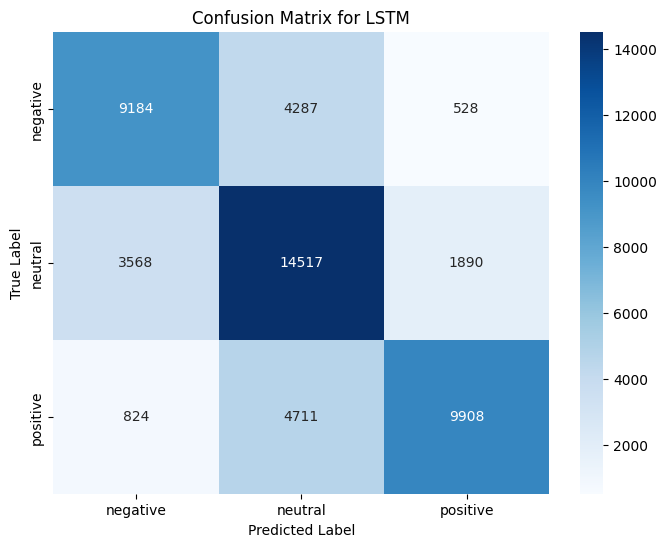

In [ ]:
class_names = ['negative', 'neutral', 'positive']

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for LSTM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


1545/1545 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step


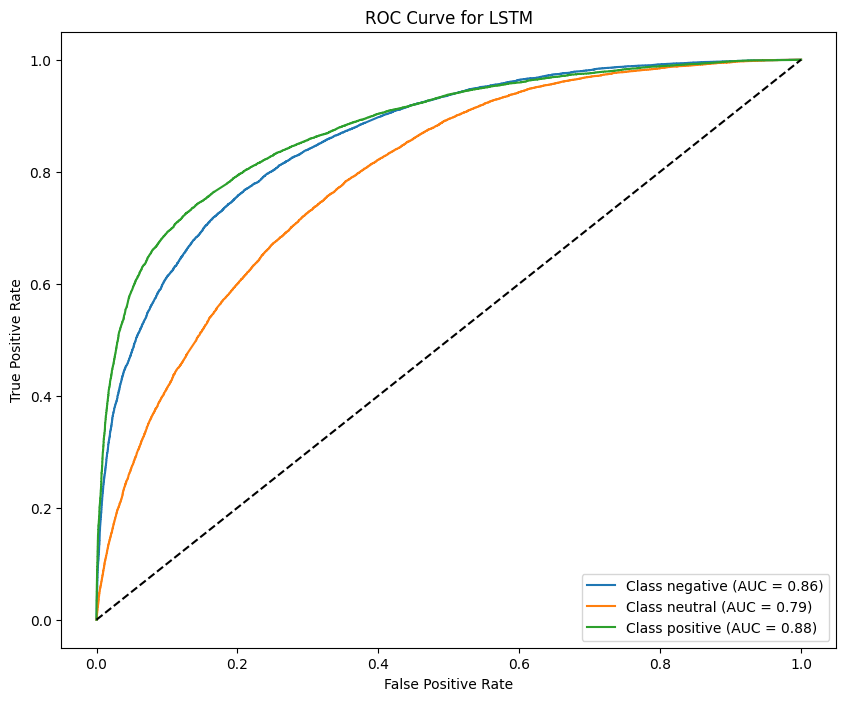

Overall AUC: 0.85


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have your tokenizer and max_length from your training phase
# If not, you'll need to recreate them

# 1. Tokenize the text in X_test
# Assuming 'tokenizer' is the Tokenizer object you used for training data
sequences = tokenizer.texts_to_sequences(X_test)

# 2. Pad the sequences to the desired length
X_test_pad = pad_sequences(sequences, maxlen=max_length, padding='post')  # Use the same max_length as in training

# 3. Now predict using the padded data
lstm_probabilities = model.predict(X_test_pad)

# Assuming y_test_bin is the binarized version of y_test
# Calculate ROC curves for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], lstm_probabilities[:, i])  # Use probabilities for each class
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve for LSTM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Calculate overall AUC using probabilities
overall_auc = roc_auc_score(y_test_bin, lstm_probabilities, average='macro')  # Use probabilities
print(f"Overall AUC: {overall_auc:.2f}")


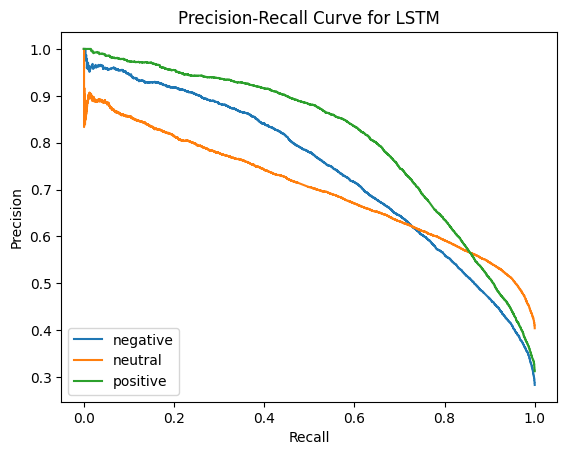

In [ ]:
class_names = ['negative', 'neutral', 'positive']

# Plot Precision-Recall curve for each class
plt.figure()
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    plt.plot(recall, precision, label=f'{class_names[i]}')

plt.title('Precision-Recall Curve for LSTM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()


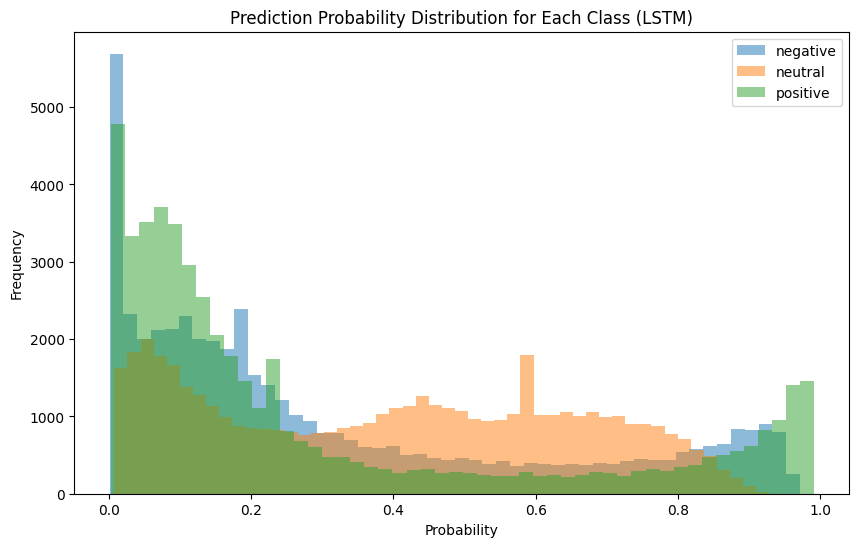

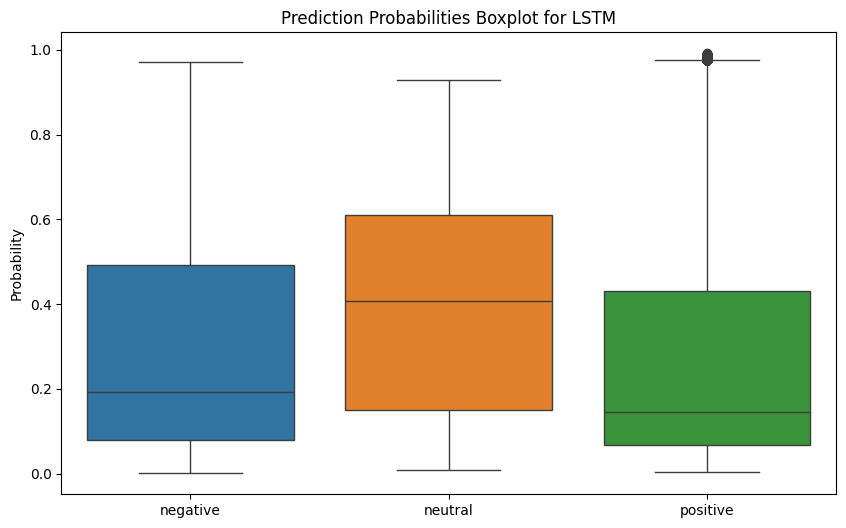

In [ ]:
class_names = ['negative', 'neutral', 'positive']

# Prediction Probabilities Distribution - Histogram
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.hist(y_test_pred_prob[:, i], bins=50, alpha=0.5, label=f'{class_names[i]}')
plt.title('Prediction Probability Distribution for Each Class (LSTM)')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

#Histogram

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert probabilities to a DataFrame for visualization
class_names = ['negative', 'neutral', 'positive']  # Replace with your actual class names
df_probabilities = pd.DataFrame(lstm_probabilities, columns=class_names)

# Create box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_probabilities)
plt.title('Prediction Probabilities Boxplot for LSTM')
plt.ylabel('Probability')
plt.show()

